In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# import seaborn as sns
# import sklearn
import warnings

from sklearn.preprocessing import LabelEncoder
# from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

warnings.filterwarnings('ignore')

In [35]:
def Extract_time(timestamp):
       time = int(timestamp[11:13]) * 60 + int(timestamp[14:16])
       return time

In [36]:
def key_of_max(d):
    try:
        return max(d, key = d.get)
    except:
        return None

In [37]:
using = {1,2,3,4,5,6,7} # all
# using = {1,2,3,4} # shorties
# using = {5,6,7} # longers
# using = {1} # ad
# using = {5,6} # custom

papers = ['ad', 'brabantsdagblad', 'destentor', 'nu', 'parool', 'trouw', 'volksrant']
features = ['brand', 'publication_timestamp', 'iptc_topics_level_0', 'iptc_topics_level_1', 'num_words', 'main_section', 'user_needs', 'lda_topics']
# features = ['brand', 'iptc_topics_level_0', 'iptc_topics_level_1']
target = 'relevance_window_in_hours'
df = None

with open('stop_words') as file:
    stop_words = file.read().split()
papers = [papers[x - 1] for x in using]

In [38]:
if 1 in using:
    df = pd.concat([df, pd.read_csv('dataset/uva-relevance-windows-ad.csv', sep=';')], ignore_index=True)
    # ad: has 99122 entries
    # target mean: 38.9

if 2 in using:
    df = pd.concat([df, pd.read_csv('dataset/uva-relevance-windows-brabantsdagblad.csv', sep=';')], ignore_index=True)
    # brabantsdagblad: has 34768 entries
    # target mean: 31.8

if 3 in using:
    df = pd.concat([df, pd.read_csv('dataset/uva-relevance-windows-destentor.csv', sep=';')], ignore_index=True)
    # destentor: has 36212 entries
    # target mean: 33.3
    
if 4 in using:
    df = pd.concat([df, pd.read_csv('dataset/uva-relevance-windows-nu.csv', sep=';')], ignore_index=True)
    # nu: has 16257 entries
    # target mean: 29.4

if 5 in using:
    df = pd.concat([df, pd.read_csv('dataset/uva-relevance-windows-parool.csv', sep=';')], ignore_index=True)
    # parool: has 7729 entries
    # target mean: 88.8

if 6 in using:
    df = pd.concat([df, pd.read_csv('dataset/uva-relevance-windows-trouw.csv', sep=';')], ignore_index=True)
    # trouw: has 8395 entries
    # target mean: 93.2

if 7 in using:
    df = pd.concat([df, pd.read_csv('dataset/uva-relevance-windows-volkskrant.csv', sep=';')], ignore_index=True)
    # volkskrant: has 10983 entries
    # target mean: 90.5


# df = df[df[target] < 48]

df.reset_index(inplace=True)
df.head()
df.info()
# df.value_counts('user_needs')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213466 entries, 0 to 213465
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   index                       213466 non-null  int64  
 1   article_id                  213466 non-null  object 
 2   brand                       213466 non-null  object 
 3   publication_timestamp       213466 non-null  object 
 4   publication_weekday         213466 non-null  object 
 5   title                       213466 non-null  object 
 6   first_paragraph             213463 non-null  object 
 7   full_body                   213463 non-null  object 
 8   num_words                   213466 non-null  int64  
 9   num_paragraphs              213466 non-null  int64  
 10  author_ids                  213466 non-null  object 
 11  labels                      79155 non-null   object 
 12  main_section                186175 non-null  object 
 13  subsections   

In [39]:
df = df.filter(features + [target])

if 'iptc_topics_level_0' in features:
    df['iptc_topics_level_0'] = df['iptc_topics_level_0'].map(eval)
    df['iptc_topics_level_0'] = df['iptc_topics_level_0'].map(key_of_max)

if 'iptc_topics_level_1' in features:
    df['iptc_topics_level_1'] = df['iptc_topics_level_1'].map(eval)
    df['iptc_topics_level_1'] = df['iptc_topics_level_1'].map(key_of_max)

if 'publication_timestamp' in features:
    df['publication_timestamp'] = df['publication_timestamp'].map(Extract_time)

if 'user_needs' in features:
    df['user_needs'] = df['user_needs'].map(eval)
    # df['user_needs'] = df['user_needs'].map(key_of_max) # testing

    normalized_info = pd.json_normalize(df['user_needs'])
    df = pd.concat([df.drop(columns=['user_needs']), normalized_info], axis=1)

if 'lda_topics' in features:
    df.rename(columns={'brand':'Brand'}, inplace=True)

    df['lda_topics'] = df['lda_topics'].map(eval)
    # df['lda_topics'] = df['lda_topics'].map(key_of_max) # testing


    normalized_info = pd.json_normalize(df['lda_topics'])
    df = pd.concat([df.drop(columns=['lda_topics']), normalized_info], axis=1)

    df.rename(columns={'brand':'lda_brand'}, inplace=True)
    df.rename(columns={'Brand':'brand'}, inplace=True)

df = pd.concat([df.drop(columns=[target]), df[target]], axis=1)

In [40]:
# %%script false --no-raise-error # skip cell, needed for regressor

df[target] = df[target].map(np.log)

X = df.drop(columns=[target])  # features
y = df.iloc[:,-1].values    # Target variable

In [41]:
%%script false --no-raise-error # skip cell, needed for classifier

df[target] = pd.cut(df[target], [0, 3, 6, 12, 24, 48, 120, 1000], labels=['0-3', '3-6', '6-12','12-24','24-48','48-120','120-1000'])
# df[target] = pd.cut(df[target], [0, 48, 1000], labels=['0-48', '48-1000'])

X = df.drop(columns=[target])  # features
y = df.iloc[:,-1].values    # Target variable



In [42]:
df

,brand,publication_timestamp,iptc_topics_level_0,iptc_topics_level_1,num_words,main_section,geef_me_context,help_me,hou_me_op_de_hoogte,raak_me_verbind_me,...,technologie_en_handel,vakbond_club_en_vereniging,veiligheid,verkeer,verkeersongevallen,voetbal,wielrennen,woon_en_leefomgeving,zingeving_en_verhalen,relevance_window_in_hours
0,ad,42,"ramp, ongeval en noodsituatie incident",noodhulp,43,regio,0.000410,0.000540,0.998421,0.000385,...,0.006848,0.003425,0.189817,0.003303,0.003148,0.006254,0.003314,0.010658,0.012742,5.141664
1,ad,43,"ramp, ongeval en noodsituatie incident",noodhulp,60,regio,0.000342,0.000544,0.998517,0.000356,...,0.004544,0.002272,0.002461,0.002191,0.247311,0.004149,0.002198,0.007061,0.008576,2.944439
2,ad,45,"kunst, cultuur, entertainment en media",kunst en vermaak,173,show,0.000399,0.000324,0.997961,0.000881,...,0.002081,0.001039,0.001125,0.001002,0.000955,0.035702,0.001005,0.003367,0.174908,2.890372
3,ad,55,"ramp, ongeval en noodsituatie incident",noodhulp,58,regio,0.000389,0.000549,0.998474,0.000387,...,0.006870,0.003436,0.003721,0.003314,0.221954,0.006274,0.003324,0.010633,0.012825,4.007333
4,ad,60,arbeid,sociale wetenschappen,504,regio,0.960950,0.002081,0.013947,0.021470,...,0.000728,0.006447,0.000394,0.000351,0.000334,0.000664,0.000352,0.294556,0.001459,2.995732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213461,volkskrant,1142,"economie, zaken en financiën",economische sector,943,tech,0.544115,0.001185,0.041880,0.408850,...,0.099351,0.004233,0.003052,0.000200,0.003636,0.012328,0.064113,0.111416,0.063821,3.044522
213462,volkskrant,1144,"conflict, oorlog en vrede",gewapend conflict,652,buitenland,0.000803,0.000315,0.998482,0.000262,...,0.000542,0.000270,0.226206,0.004874,0.000248,0.005191,0.013187,0.068046,0.024602,2.833213
213463,volkskrant,1256,politiek,misdrijf,567,columns-opinie,0.980264,0.000649,0.018013,0.000610,...,0.064103,0.033110,0.000318,0.000283,0.000270,0.013487,0.102838,0.059447,0.010247,4.477337
213464,volkskrant,1379,levensstijl en vrije tijd,vrije tijd,460,beter-leven,0.000615,0.995157,0.001436,0.000404,...,0.000926,0.000461,0.000500,0.000445,0.015873,0.023816,0.000446,0.001440,0.076252,6.107023


In [43]:
label_encoder = LabelEncoder()
x_categorical = X.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = X.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split( 
          x, y, test_size = 0.1)

In [44]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(
    criterion='squared_error',
    min_samples_leaf=20,
    n_estimators=50, 
    random_state=0, 
    oob_score=True
    )
# regressor = RandomForestClassifier(
#     max_depth=25,
#     min_samples_leaf=30, 
#     criterion='entropy', 
#     n_estimators=100, 
#     random_state=0, 
#     oob_score=True,
#     )

# Fit the regressor with x and y data
regressor.fit(x_train, y_train)

RandomForestRegressor(min_samples_leaf=20, n_estimators=50, oob_score=True,
                      random_state=0)

In [45]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score

# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Making predictions
predictions = regressor.predict(x_test)

y_train_pred = regressor.predict(x_train)
y_test_pred = regressor.predict(x_test)

# Evaluating the model
y_train_pred = [int(x) for x in y_train_pred] # needed for regressor
y_test_pred = [int(x) for x in y_test_pred] # needed for regressor

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


print("Train Accuracy: %.1f%%" %(train_accuracy * 100))
print("Test Accuracy: %.1f%%" %(test_accuracy * 100))


mse = mean_squared_error(y_test, predictions) # needed for regressor
print(f'Mean Squared Error: {mse}') # needed for regressor

r2 = r2_score(y_test, predictions) # needed for regressor
print(f'R-squared: {r2}') # needed for regressor

# takes a long time to compute
# cross_value_score = cross_val_score(regressor, x_train, y_train)
# print(f'cross_value_score: {cross_value_score}')


Out-of-Bag Score: 0.36743326557330147


ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

Out-of-Bag Score: 0.28110463383846884 <br>
Train Accuracy: 2.0% <br>
Test Accuracy: 1.9% <br>
Mean Squared Error: 2386.088419847645 <br>
R-squared: 0.2734062099924697 <br>

## 8 trees
### All papers
Out-of-Bag Score: -0.010385546076016938 <br>
Mean Squared Error: 2534.456497179695 <br>
R-squared: 0.20268255231773014 <br>

## 100 trees
### All paper
Out-of-Bag Score: 0.25749810100135195 <br>
Train Accuracy: 6.1% <br>
Test Accuracy: 1.8% <br>
Mean Squared Error: 2331.636670402366 <br>
R-squared: 0.26020977003388635 <br>
cross_value_score: [0.2676171  0.26389397 0.25197756 0.27269653 0.27264813] <br>

### All papers, regressor
Out-of-Bag Score: 0.2943318712607208<br>
Train Accuracy: 2.3%<br>
Test Accuracy: 1.8%<br>
Mean Squared Error: 2264.787157875292<br>
R-squared: 0.2969975768644405<br>

In [29]:
%%script false --no-raise-error # skip cell, Visualization

X_grid = np.linspace(0,1000,1)
X_grid = X_grid.reshape(len(X_grid),1) 
  
plt.scatter(X,y, color='blue') #plotting real points
plt.plot(X_grid, regressor.predict(X_grid),color='green') #plotting for predict points
  
plt.title("Random Forest Regression Results")
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

In [30]:
# %%script false --no-raise-error # skip cell, Tree Visualization

# Plot the decision tree
def plotting_tree(tree):
    # print("Worker thread running")
    n, tree_to_plot = tree
    plt.figure(figsize=(20, 10))
    plot_tree(tree_to_plot, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
    plt.title(f"Decision Tree {n} from Random Forest")
    plt.show()

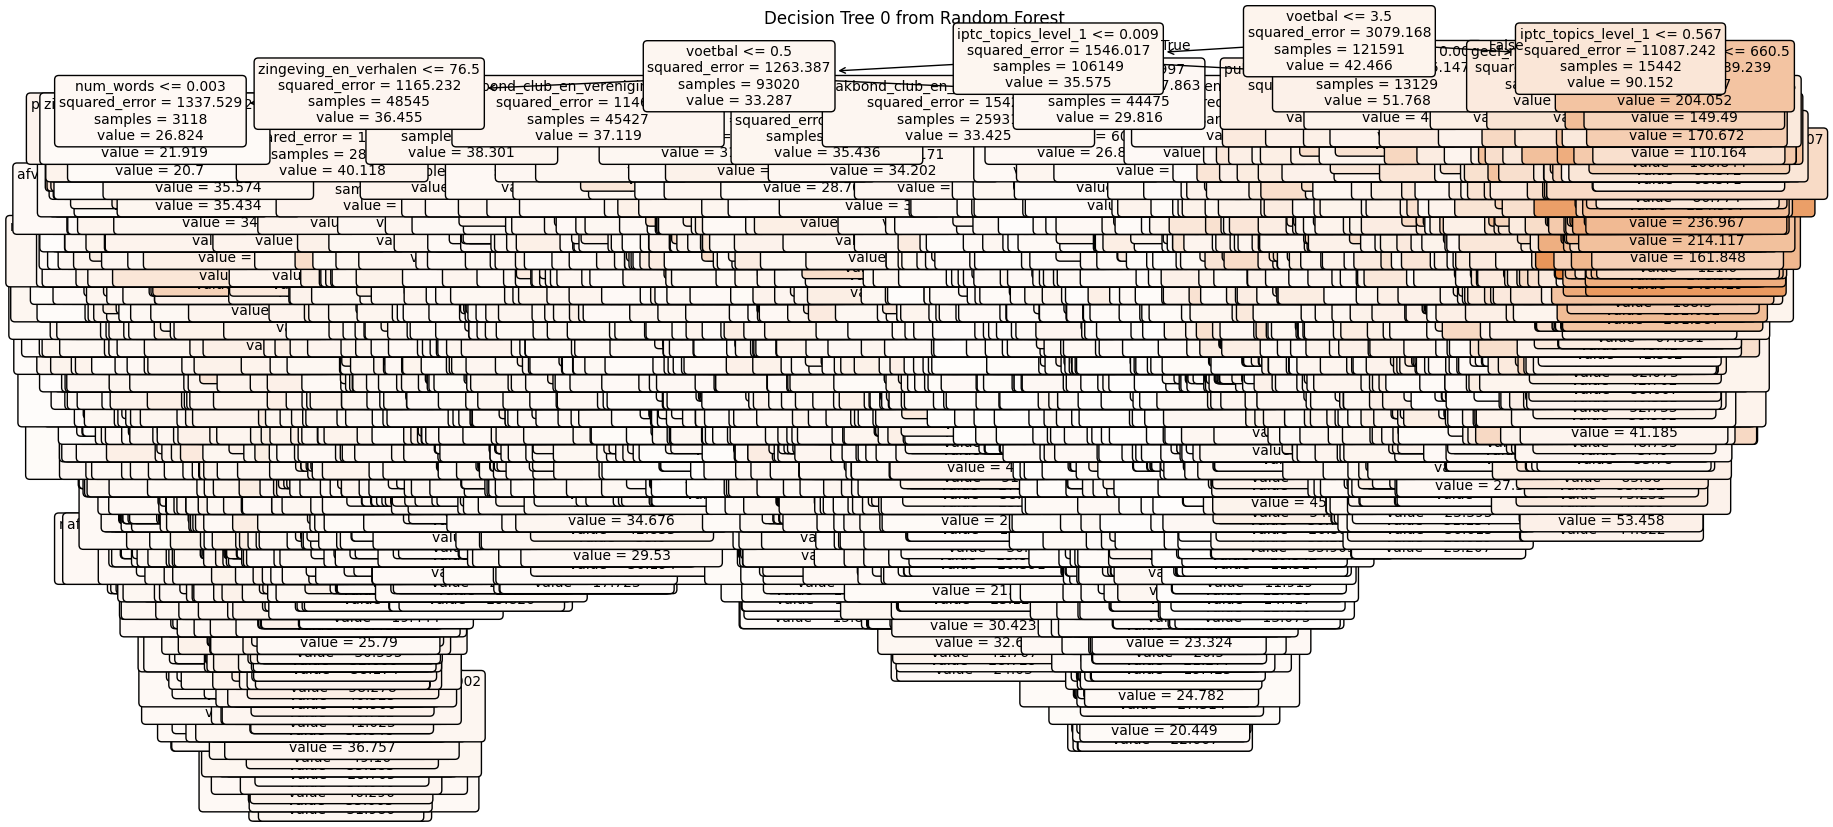

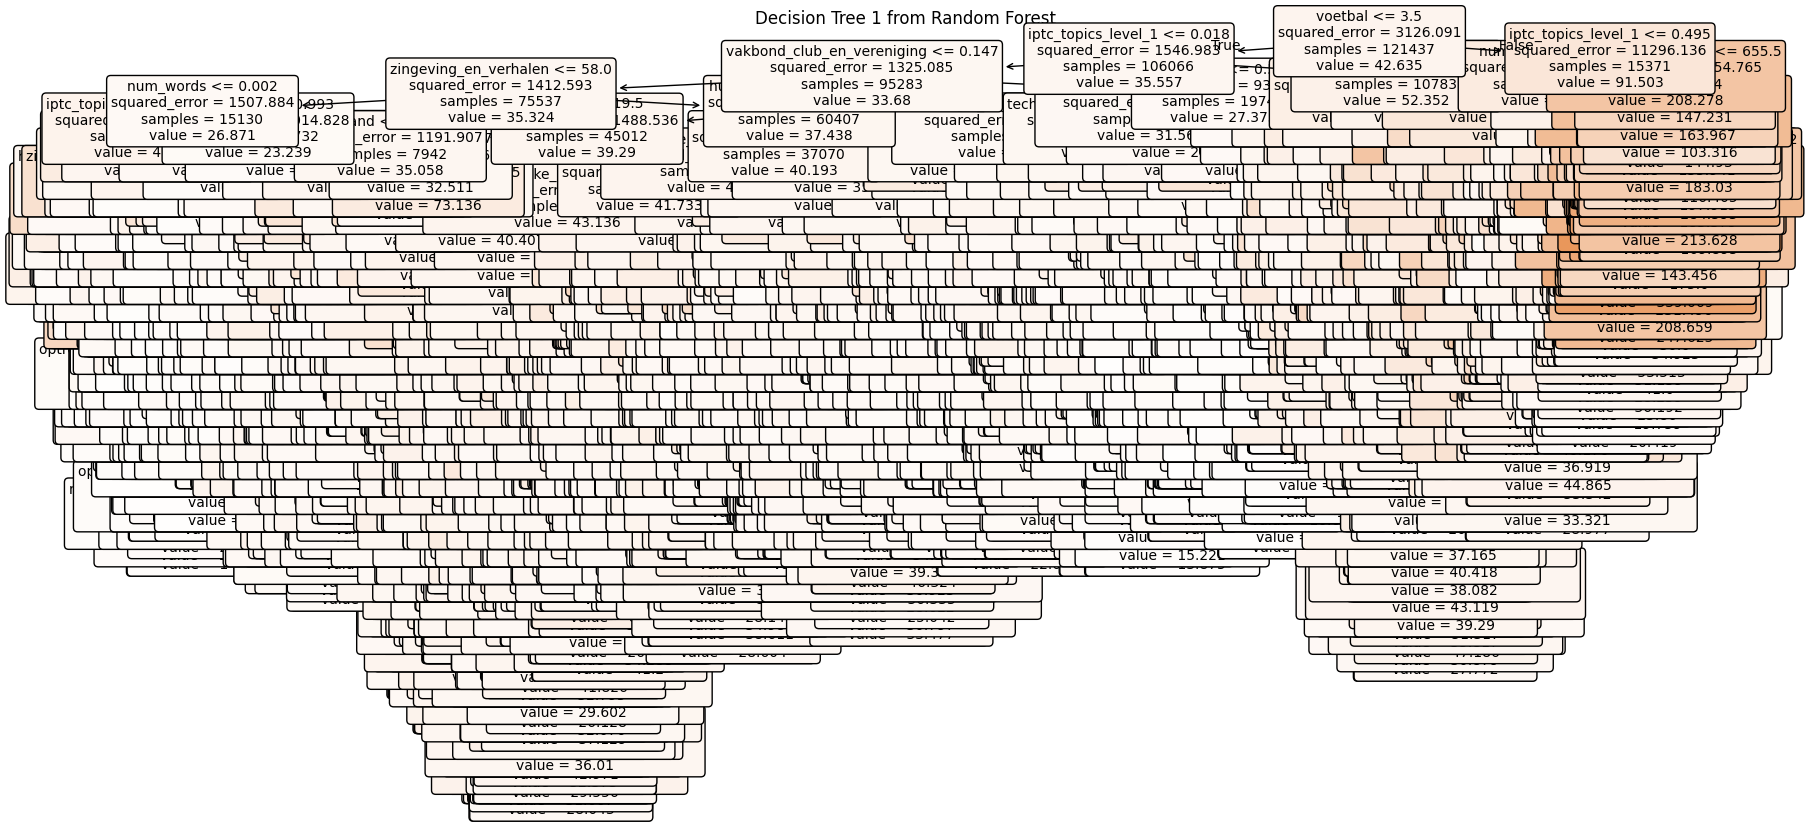

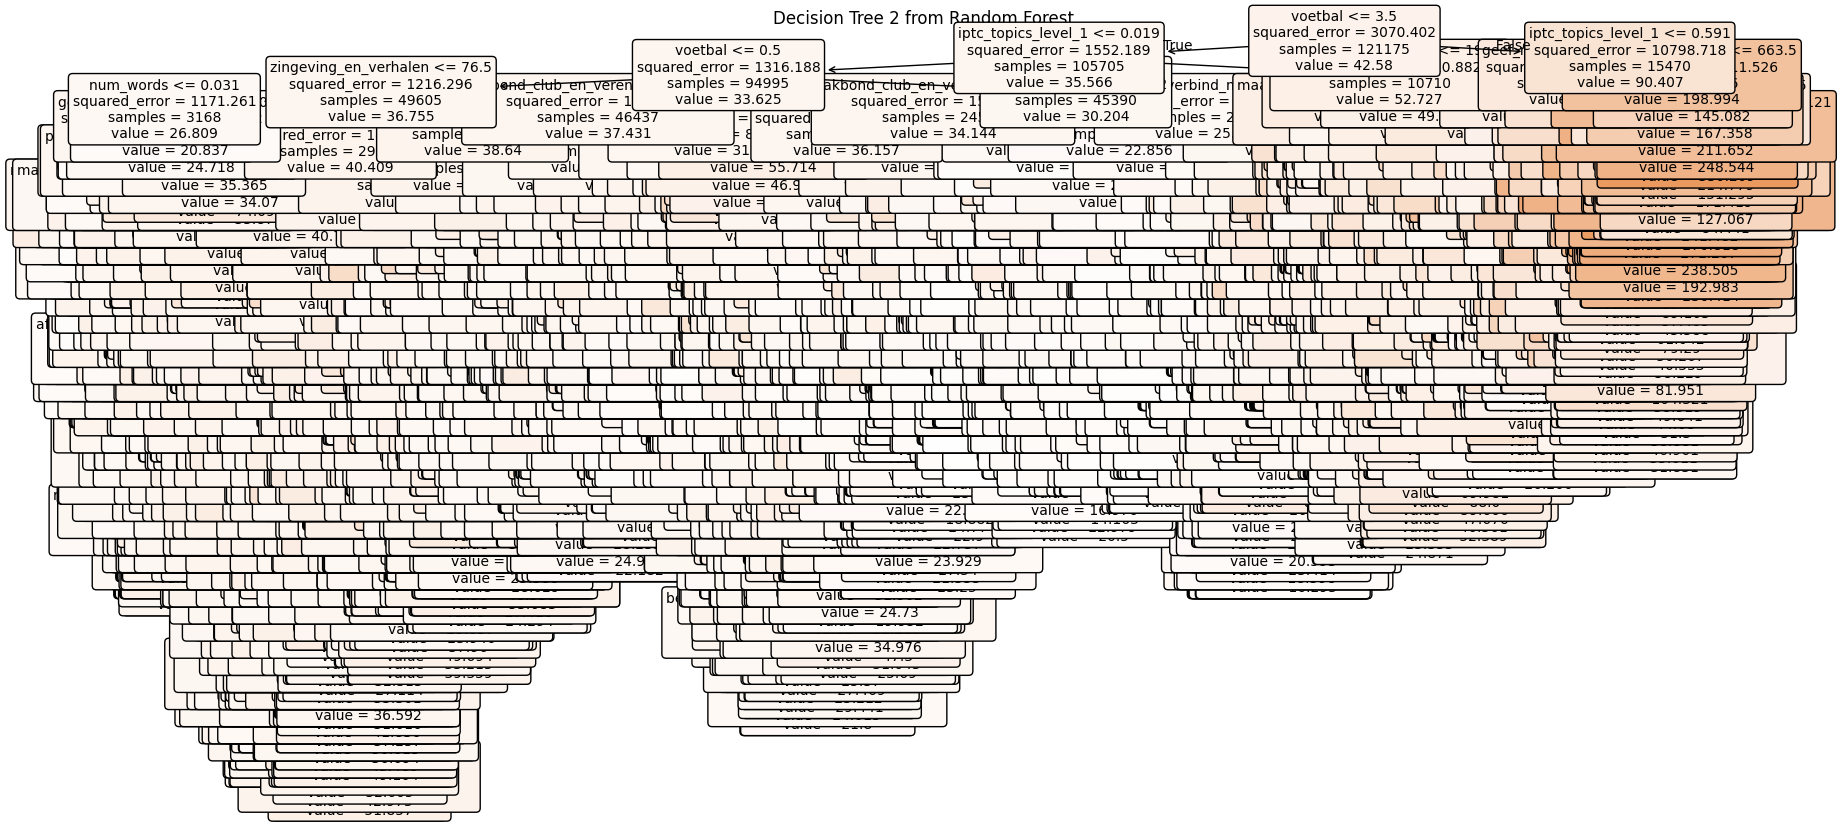

KeyboardInterrupt: 

In [33]:
# %%script false --no-raise-error # skip cell, Tree Visualization

for tree in enumerate(regressor.estimators_):
    plotting_tree(tree)

In [32]:
%%script false --no-raise-error # skip cell, Tree Visualization

import concurrent.futures    

pool = concurrent.futures.ThreadPoolExecutor(max_workers=10)

for tree in enumerate(regressor.estimators_):
    pool.submit(plotting_tree, tree)

print('All trees submitted')

pool.shutdown(wait=True)

print("Main thread continuing to run")